In [70]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os

%matplotlib notebook
#%matplotlib inline

from ipywidgets import interact #, interactive, fixed, interact_manual
import ipywidgets as widgets

def rename_string_to_label(string):
    return(string.replace('b-pulseAlongX_0.22','UV').replace('z-from_S1_without_pulse','FC_1').replace('m-only_IR_longer_with_nac_2_1','IR_long').replace('_0000',''))

# READING DATA

In [71]:
fol = '/home/alessio/k-nokick/'

subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir not in ['HTML','csv']])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> IMPORTANTS
1 -> b-pulseAlongX_0.22_goodG_0000
2 -> b-pulseAlongX_0.22_short_0_goodG_0000
3 -> b-pulseAlongX_0.22_short_pi_goodG_0000
4 -> m-only_IR_longer_with_nac_2_1_0000
5 -> m-only_IR_longer_with_nac_2_1_counterClock_0000
6 -> m-only_IR_longer_with_nac_2_1_inverted_phase_0000
7 -> m-only_IR_longer_with_nac_2_1_phase_pi_0000
8 -> m-only_IR_short_with_nac_2_1_0000
9 -> m-only_IR_short_with_nac_2_1_inverted_phase_0000
10 -> m-only_IR_short_with_nac_2_1_phase_pi_0000
11 -> z-from_S1_without_pulse_0000
12 -> z-from_S2_without_pulse_0000



In [72]:
def create_df_from_files_given_name(name,fol,fs_end_pulse):
    '''
    This creates the excel file from the 4 files
    '''
    project_folder = os.path.join(fol,name)
    
    output_norm = os.path.join(project_folder, 'output')
    output_popu = os.path.join(project_folder, 'outputPopul')
    output_abso = os.path.join(project_folder, 'Output_Abs')
    output_regi = os.path.join(project_folder, 'Output_Regions')
    
    df_norm2 = pd.read_csv(output_norm, delim_whitespace=True, index_col=0, names=['counter', 'steps', 'fs','Norm deviation','Kinetic','Potential','Total','Total Deviation','Xpulse','Ypulse','Zpulse'])
    df_popu2 = pd.read_csv(output_popu, delim_whitespace=True, names=['fs', 'S0', 'S1','S2','S3','S4','S5','S6','S7'])
    df_abso2 = pd.read_csv(output_abso, delim_whitespace=True, names=['Time AU', 'Abs Tot', 'Abs S0', 'Abs S1','Abs S2','Abs S3','Abs S4','Abs S5','Abs S6','Abs S7'])
    df_regi2 = pd.read_csv(output_regi, delim_whitespace=True, names=['FC','Reactants','Products'])
    

    # I need to cut down to different file size <- this will become obsolete
    dfs = [df_norm2,df_popu2,df_abso2,df_regi2]
    lengths = min([x.shape[0] for x in dfs])
    print('I will cut down to {}'.format(lengths))
    df_norm, df_popu, df_abso, df_regi = [ x.drop(x.index[lengths:]) for x in dfs ]
    
    AU_dt = df_abso['Time AU'].iloc[1]
    
    df_abso['Norm Tot'] = df_abso['Abs Tot'] / AU_dt
    df_abso['Norm S0']  = df_abso['Abs S0'] / AU_dt 
    df_abso['Norm S1']  = df_abso['Abs S1'] / AU_dt 
    df_abso['Norm S2']  = df_abso['Abs S2'] / AU_dt 
    df_abso['Norm S3']  = df_abso['Abs S3'] / AU_dt 
    df_abso['Norm S4']  = df_abso['Abs S4'] / AU_dt 
    df_abso['Norm S5']  = df_abso['Abs S5'] / AU_dt 
    df_abso['Norm S6']  = df_abso['Abs S6'] / AU_dt 
    df_abso['Norm S7']  = df_abso['Abs S7'] / AU_dt
    
    #fs_end_pulse = 15 # this is where I start to count Fc population retourning in S0 after the pulse.
    fs_array = df_norm2['fs']
    filtering_on_indexes = np.arange(lengths)
    number_line_after_pulse = np.where(fs_array > fs_end_pulse)[0][0]
    
    fs_after_pulse = df_popu['fs'].iloc[number_line_after_pulse]
    s0_after_pulse = df_popu['S0'].iloc[number_line_after_pulse]
    s1_after_pulse = df_popu['S1'].iloc[number_line_after_pulse]
    s2_after_pulse = df_popu['S2'].iloc[number_line_after_pulse]
    s3_after_pulse = df_popu['S3'].iloc[number_line_after_pulse]
    s4_after_pulse = df_popu['S4'].iloc[number_line_after_pulse]
    s5_after_pulse = df_popu['S5'].iloc[number_line_after_pulse]
    s6_after_pulse = df_popu['S6'].iloc[number_line_after_pulse]
    s7_after_pulse = df_popu['S7'].iloc[number_line_after_pulse]
    
    all_after_pulse = np.array([s0_after_pulse,s1_after_pulse,s2_after_pulse,s3_after_pulse,s4_after_pulse,s5_after_pulse,s6_after_pulse,s7_after_pulse])
    
    print('At time {}'.format(fs_after_pulse,s1_after_pulse,s2_after_pulse,s3_after_pulse,s4_after_pulse))
    
    if number_line_after_pulse != 0:
        value_to_subtract = df_regi['FC'].iloc[number_line_after_pulse-1]
        df_regi['FC after pulse'] = np.where( filtering_on_indexes < number_line_after_pulse, 0, (df_regi['FC']-value_to_subtract))
    else:
        df_regi['FC after pulse'] = df_regi['FC']
        
    df_regi['Real Reactants'] = df_regi['Reactants'] + df_regi['FC after pulse']
    df_regi['Real Products'] = df_regi['Products'] + df_abso['Norm S0']
    
    df_all = pd.concat([df_norm,df_popu,df_abso,df_regi],axis=1)
    
    csv_name = '{}.csv'.format(project_folder)
    print('saving file {}'.format(csv_name))
    
    df_all.to_csv(csv_name)
    
    df_all['ratio'] = df_all['Products']/df_all['Reactants']
    df_all['Real ratio'] = df_all['Real Products']/df_all['Real Reactants']

    # ok this part needs comment. We want to normalize the S1 population to 1, to make the absorbed product count "fair"
    # But the population in S1 is "moving" due to the other states continuosly absorbing/feeding it
    # We make the assumption that all the other states are a single superstate that "feeds" only S1.
    # So we sum up states from S2 to S7. Then we take the population of those states (2 to 7) after the pulse. We want to 
    # know after the pulse what is the CHANGE in population due to NAC of this "super state".
    # our normalization factor for S1 at time T is ten the 
    
    df_all['sum_others'] = (df_all['S2'] + df_all['S3'] + df_all['S4'] + df_all['S5'] + df_all['S6'] + df_all['S7'])
    
    df_all['sum_others_minus_after_pulse'] = sum(all_after_pulse[2:]) - df_all['sum_others']
    
    df_all['Norm_factor (t)'] = all_after_pulse[1] + df_all['sum_others_minus_after_pulse']
    
    df_all['Absorbed Normalized'] = df_all['Norm S0'] / df_all['Norm_factor (t)']
    
    
    
    #df_all.plot('fs',['Reactants','Products'])
    #df_all.plot('fs','ratio')
    #df_all.plot('fs',['Real Reactants','Real Products'])
    #return(df_all[['fs','Norm_factor (t)','sum_others_minus_after_pulse','sum_others']])
    return(df_all[['fs','ratio','Real Products','Real Reactants','Norm S0', 'Products', 'Reactants','Real ratio','S1','S2','S3','S0','S4','S5','S6','S7','Xpulse','Ypulse','Norm_factor (t)','sum_others_minus_after_pulse','sum_others','Absorbed Normalized']])

number = 3

a = create_df_from_files_given_name('z-from_S1_without_pulse_0000',fol,0)
b = create_df_from_files_given_name('b-pulseAlongX_0.22_goodG_0000',fol,15)
c = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_0000',fol,15)
d = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_counterClock_0000',fol,15)
e = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_inverted_phase_0000',fol,15)
f = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_phase_pi_0000',fol,15)
g = create_df_from_files_given_name('m-only_IR_short_with_nac_2_1_0000',fol,15)
h = create_df_from_files_given_name('m-only_IR_short_with_nac_2_1_inverted_phase_0000',fol,15)
i = create_df_from_files_given_name('m-only_IR_short_with_nac_2_1_phase_pi_0000',fol,15)
l = create_df_from_files_given_name('b-pulseAlongX_0.22_short_0_goodG_0000',fol,15)
m = create_df_from_files_given_name('b-pulseAlongX_0.22_short_pi_goodG_0000',fol,15)

I will cut down to 2001
At time 0.1001
saving file /home/alessio/k-nokick/z-from_S1_without_pulse_0000.csv
I will cut down to 4001
At time 15.015
saving file /home/alessio/k-nokick/b-pulseAlongX_0.22_goodG_0000.csv
I will cut down to 4001
At time 15.015
saving file /home/alessio/k-nokick/m-only_IR_longer_with_nac_2_1_0000.csv
I will cut down to 4001
At time 15.015
saving file /home/alessio/k-nokick/m-only_IR_longer_with_nac_2_1_counterClock_0000.csv
I will cut down to 4001
At time 15.015
saving file /home/alessio/k-nokick/m-only_IR_longer_with_nac_2_1_inverted_phase_0000.csv
I will cut down to 4001
At time 15.015
saving file /home/alessio/k-nokick/m-only_IR_longer_with_nac_2_1_phase_pi_0000.csv
I will cut down to 4001
At time 15.015
saving file /home/alessio/k-nokick/m-only_IR_short_with_nac_2_1_0000.csv
I will cut down to 4001
At time 15.015
saving file /home/alessio/k-nokick/m-only_IR_short_with_nac_2_1_inverted_phase_0000.csv
I will cut down to 4001
At time 15.015
saving file /home/

In [73]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']

# UV vs FC

<IPython.core.display.Javascript object>


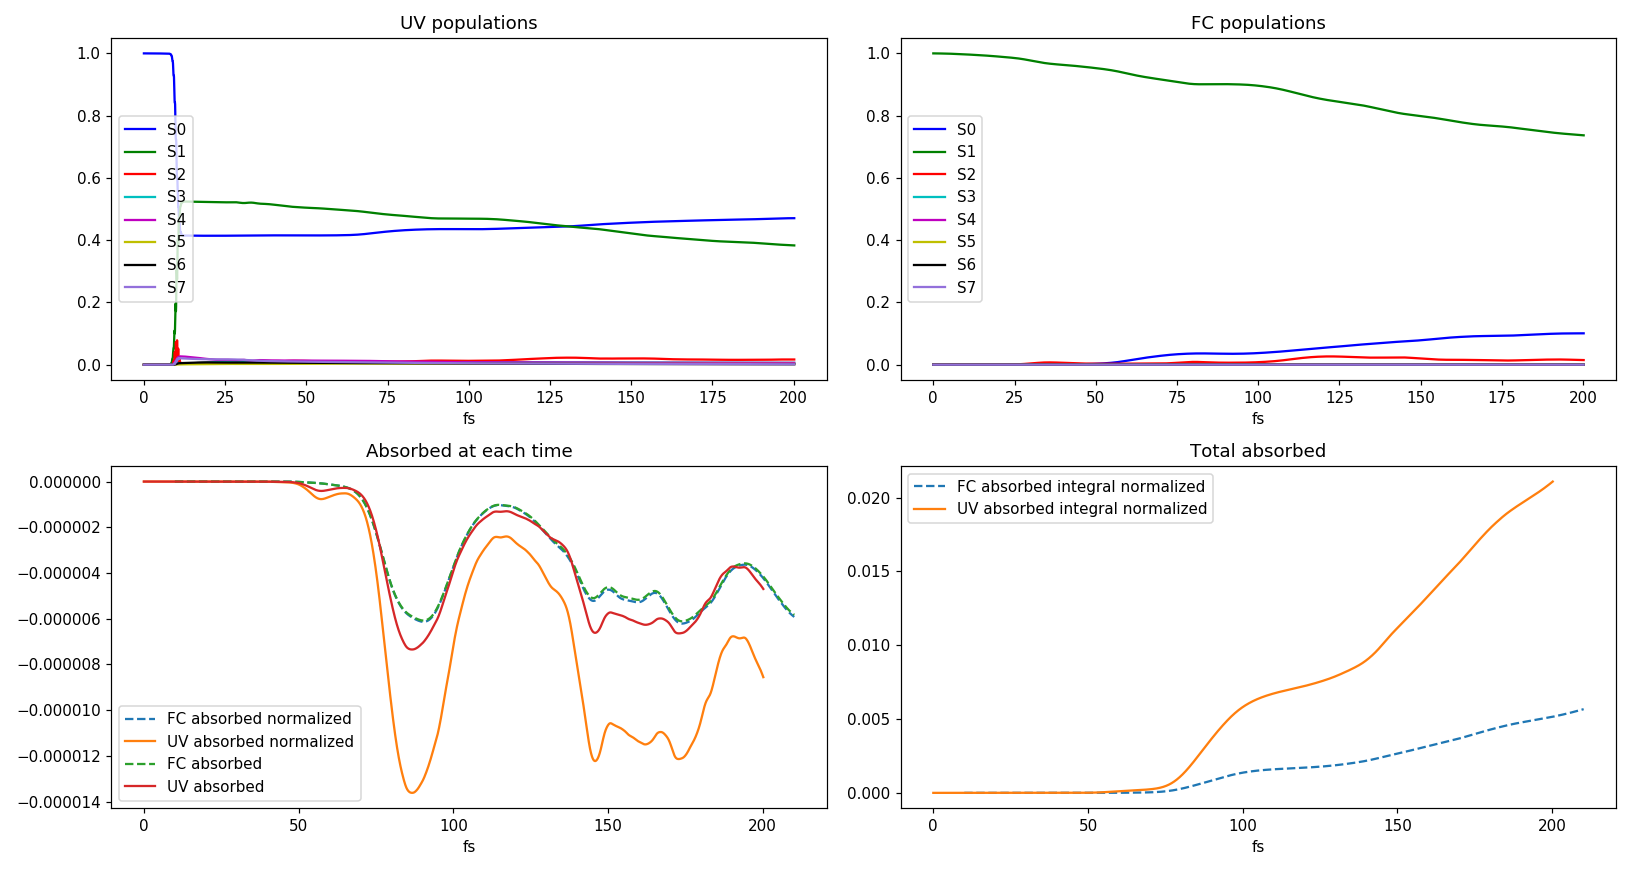

In [74]:
fig, [[ax0, ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(15,8))

# ax0.plot(a['fs'].iloc[:,1]+10,  a['Real Products'], label='FC products',ls='--')
# ax0.plot(a['fs'].iloc[:,1]+10,  a['Real Reactants'], label='FC reactants',ls='--')
# ax0.plot(b['fs'].iloc[:,1],     b['Real Products']/normG, label='UV products')
# ax0.plot(b['fs'].iloc[:,1],     b['Real Reactants']/normG, label='UV reactants')
# ax0.plot(a['fs'].iloc[:,1]+10,  a['Products'], label='FC products',ls='--')
# ax0.plot(a['fs'].iloc[:,1]+10,  a['Reactants'], label='FC reactants',ls='--')
# ax0.plot(b['fs'].iloc[:,1],     b['Products']/normG, label='UV products')
# ax0.plot(b['fs'].iloc[:,1],     b['Reactants']/normG, label='UV reactants')
# ax0.set_title(title1)
# ax1.plot(a['fs'].iloc[:,1]+10,  a['Real ratio'], label='FC')
# ax1.plot(b['fs'].iloc[:,1],     b['Real ratio'], label='UV')
# ax1.set_xlim(0,200)
# ax1.set_title(title2)

ax0.plot(b['fs'].iloc[:,1], b['S0'], label='S0', color=colors[0])
ax0.plot(b['fs'].iloc[:,1], b['S1'], label='S1', color=colors[1])
ax0.plot(b['fs'].iloc[:,1], b['S2'], label='S2', color=colors[2])
ax0.plot(b['fs'].iloc[:,1], b['S3'], label='S3', color=colors[3])
ax0.plot(b['fs'].iloc[:,1], b['S4'], label='S4', color=colors[4])
ax0.plot(b['fs'].iloc[:,1], b['S5'], label='S5', color=colors[5])
ax0.plot(b['fs'].iloc[:,1], b['S6'], label='S6', color=colors[6])
ax0.plot(b['fs'].iloc[:,1], b['S7'], label='S7', color=colors[7])
ax0.set_title('UV populations')
ax0.set_xlabel('fs')
ax0.legend()

ax1.plot(a['fs'].iloc[:,1], a['S0'], label='S0', color=colors[0])
ax1.plot(a['fs'].iloc[:,1], a['S1'], label='S1', color=colors[1])
ax1.plot(a['fs'].iloc[:,1], a['S2'], label='S2', color=colors[2])
ax1.plot(a['fs'].iloc[:,1], a['S3'], label='S3', color=colors[3])
ax1.plot(a['fs'].iloc[:,1], a['S4'], label='S4', color=colors[4])
ax1.plot(a['fs'].iloc[:,1], a['S5'], label='S5', color=colors[5])
ax1.plot(a['fs'].iloc[:,1], a['S6'], label='S6', color=colors[6])
ax1.plot(a['fs'].iloc[:,1], a['S7'], label='S7', color=colors[7])
ax1.set_title('FC populations')
ax1.set_xlabel('fs')
ax1.legend()

ax2.plot(a['fs'].iloc[:,1]+10, a['Absorbed Normalized'], label='FC absorbed normalized', ls='--')
ax2.plot(b['fs'].iloc[:,1],    b['Absorbed Normalized'], label='UV absorbed normalized')
ax2.plot(a['fs'].iloc[:,1]+10, a['Norm S0'], label='FC absorbed', ls='--')
ax2.plot(b['fs'].iloc[:,1],    b['Norm S0'], label='UV absorbed')
ax2.set_title(title3)
ax2.set_xlabel('fs')
ax2.legend()

ax3.plot(a['fs'].iloc[:,1]+10, -np.cumsum(a['Absorbed Normalized']), label='FC absorbed integral normalized', ls='--')
ax3.plot(b['fs'].iloc[:,1],    -np.cumsum(b['Absorbed Normalized']), label='UV absorbed integral normalized')
ax3.set_title(title4)
ax3.set_xlabel('fs')
ax3.legend()

fig.tight_layout();

# IR ones

<IPython.core.display.Javascript object>


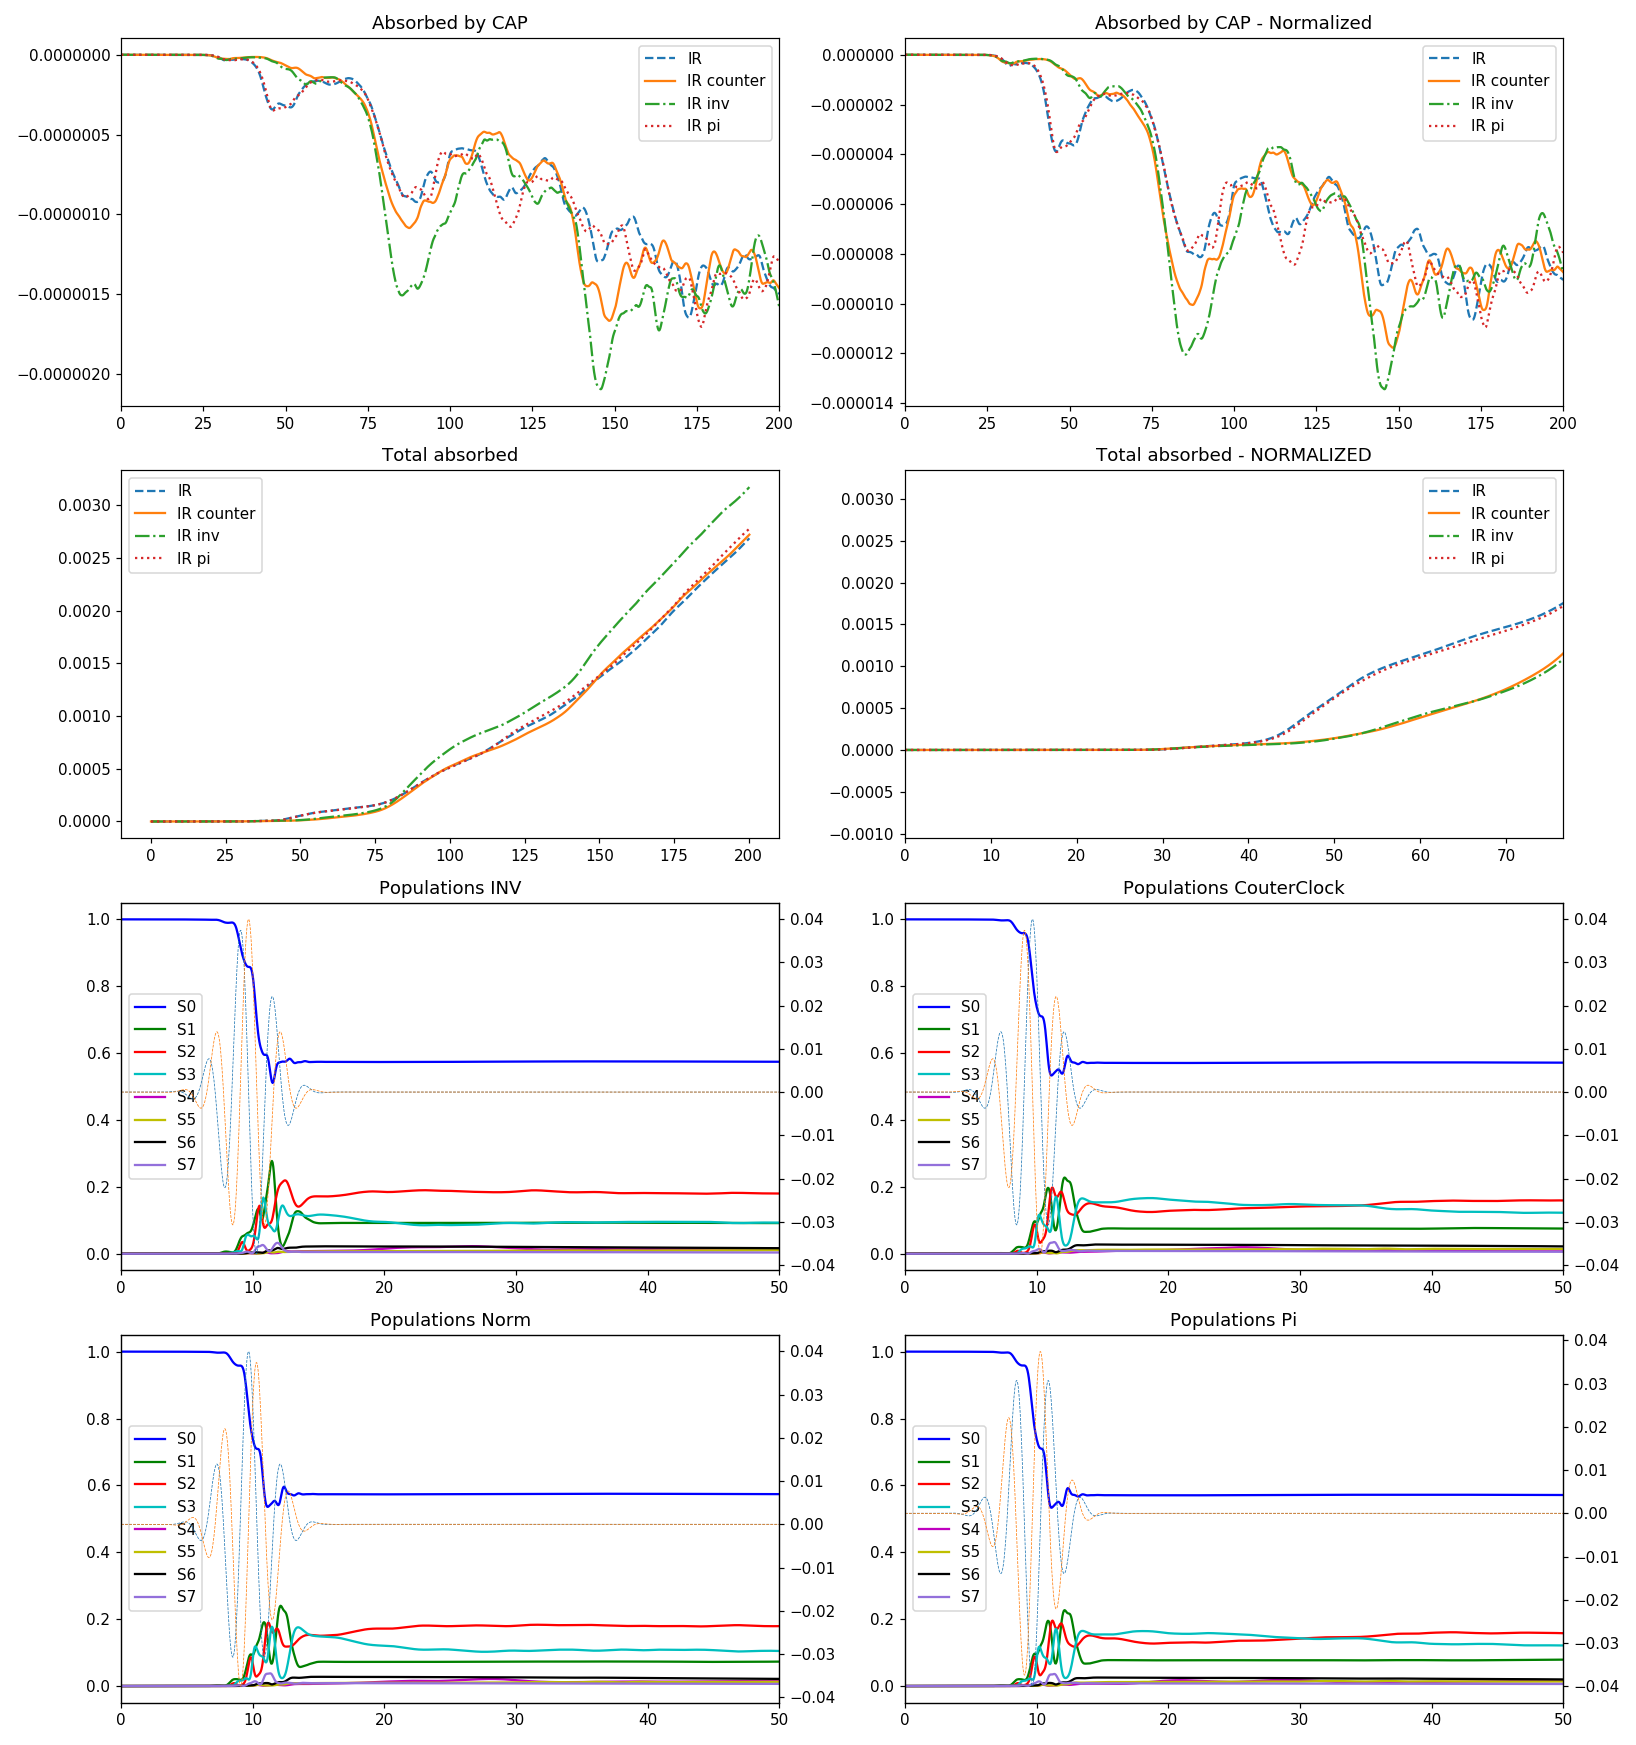

In [43]:
fig, [[ax0, ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(15,16))

# normG = 1
# #normG = 0.523

# ax0.plot(c['fs'].iloc[:,1],  c['Products'], label='IR products',ls='--')
# ax0.plot(c['fs'].iloc[:,1],  c['Reactants'], label='IR reactants',ls='--')
# ax0.plot(d['fs'].iloc[:,1],  d['Products'], label='IR counter products')
# ax0.plot(d['fs'].iloc[:,1],  d['Reactants'], label='IR counter reactants')
# ax0.plot(e['fs'].iloc[:,1],  e['Products'], label='IR inv products',ls='-.')
# ax0.plot(e['fs'].iloc[:,1],  e['Reactants'], label='IR inv reactants',ls='-.')
# ax0.plot(f['fs'].iloc[:,1],  f['Products'], label='IR pi products',ls=':')
# ax0.plot(f['fs'].iloc[:,1],  f['Reactants'], label='IR pi reactants',ls=':')
# ax0.set_title(title1)
# ax0.set_xlim(0,200)
# ax0.set_ylim(0,0.01)
# ax0.legend()

# ax1.plot(c['fs'].iloc[:,1],     c['ratio'], label='IR',ls='--')
# ax1.plot(d['fs'].iloc[:,1],     d['ratio'], label='IR counter')
# ax1.plot(e['fs'].iloc[:,1],     e['ratio'], label='IR inv',ls='-.')
# ax1.plot(f['fs'].iloc[:,1],     f['ratio'], label='IR pi',ls=':')
# ax1.set_title(title2)
# ax1.set_xlim(0,200)
# ax1.legend()

ax0.plot(c['fs'].iloc[:,1],     c['Norm S0'], label='IR',ls='--')
ax0.plot(d['fs'].iloc[:,1],     d['Norm S0'], label='IR counter')
ax0.plot(e['fs'].iloc[:,1],     e['Norm S0'], label='IR inv',ls='-.')
ax0.plot(f['fs'].iloc[:,1],     f['Norm S0'], label='IR pi',ls=':')
ax0.set_title('Absorbed by CAP')
ax0.set_xlim(0,200)
ax0.legend()

ax1.plot(c['fs'].iloc[:,1],     c['Absorbed Normalized'], label='IR',ls='--')
ax1.plot(d['fs'].iloc[:,1],     d['Absorbed Normalized'], label='IR counter')
ax1.plot(e['fs'].iloc[:,1],     e['Absorbed Normalized'], label='IR inv',ls='-.')
ax1.plot(f['fs'].iloc[:,1],     f['Absorbed Normalized'], label='IR pi',ls=':')
ax1.set_title('Absorbed by CAP - Normalized')
ax1.set_xlim(0,200)
ax1.legend()

ax2.plot(c['fs'].iloc[:,1],     -np.cumsum(c['Norm S0']), label='IR',ls='--')
ax2.plot(d['fs'].iloc[:,1],     -np.cumsum(d['Norm S0']), label='IR counter')
ax2.plot(e['fs'].iloc[:,1],     -np.cumsum(e['Norm S0']), label='IR inv',ls='-.')
ax2.plot(f['fs'].iloc[:,1],     -np.cumsum(f['Norm S0']), label='IR pi',ls=':')
ax2.set_title('Total absorbed')
ax2.legend()

ax3.plot(c['fs'].iloc[:,1],     -np.cumsum(c['Absorbed Normalized']), label='IR',ls='--')
ax3.plot(d['fs'].iloc[:,1],     -np.cumsum(d['Absorbed Normalized']), label='IR counter')
ax3.plot(e['fs'].iloc[:,1],     -np.cumsum(e['Absorbed Normalized']), label='IR inv',ls='-.')
ax3.plot(f['fs'].iloc[:,1],     -np.cumsum(f['Absorbed Normalized']), label='IR pi',ls=':')
ax3.set_title('Total absorbed - NORMALIZED')
ax3.legend()


ax4.plot(e['fs'].iloc[:,1], e['S0'], label='S0', color=colors[0])
ax4.plot(e['fs'].iloc[:,1], e['S1'], label='S1', color=colors[1])
ax4.plot(e['fs'].iloc[:,1], e['S2'], label='S2', color=colors[2])
ax4.plot(e['fs'].iloc[:,1], e['S3'], label='S3', color=colors[3])
ax4.plot(e['fs'].iloc[:,1], e['S4'], label='S4', color=colors[4])
ax4.plot(e['fs'].iloc[:,1], e['S5'], label='S5', color=colors[5])
ax4.plot(e['fs'].iloc[:,1], e['S6'], label='S6', color=colors[6])
ax4.plot(e['fs'].iloc[:,1], e['S7'], label='S7', color=colors[7])

ax44 = ax4.twinx()
ax44.plot(e['fs'].iloc[:,1], e['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax44.plot(e['fs'].iloc[:,1], e['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax4.set_title('Populations INV')
#ax4.set_ylim(0,0.3)
ax4.set_xlim(0,50)
ax4.legend()

ax5.plot(c['fs'].iloc[:,1], c['S0'], label='S0', color=colors[0])
ax5.plot(c['fs'].iloc[:,1], c['S1'], label='S1', color=colors[1])
ax5.plot(c['fs'].iloc[:,1], c['S2'], label='S2', color=colors[2])
ax5.plot(c['fs'].iloc[:,1], c['S3'], label='S3', color=colors[3])
ax5.plot(c['fs'].iloc[:,1], c['S4'], label='S4', color=colors[4])
ax5.plot(c['fs'].iloc[:,1], c['S5'], label='S5', color=colors[5])
ax5.plot(c['fs'].iloc[:,1], c['S6'], label='S6', color=colors[6])
ax5.plot(c['fs'].iloc[:,1], c['S7'], label='S7', color=colors[7])

ax55 = ax5.twinx()
ax55.plot(c['fs'].iloc[:,1], c['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax55.plot(c['fs'].iloc[:,1], c['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax5.set_title('Populations CouterClock')
ax5.set_xlim(0,50)
ax5.legend()


ax6.plot(d['fs'].iloc[:,1], d['S0'], label='S0', color=colors[0])
ax6.plot(d['fs'].iloc[:,1], d['S1'], label='S1', color=colors[1])
ax6.plot(d['fs'].iloc[:,1], d['S2'], label='S2', color=colors[2])
ax6.plot(d['fs'].iloc[:,1], d['S3'], label='S3', color=colors[3])
ax6.plot(d['fs'].iloc[:,1], d['S4'], label='S4', color=colors[4])
ax6.plot(d['fs'].iloc[:,1], d['S5'], label='S5', color=colors[5])
ax6.plot(d['fs'].iloc[:,1], d['S6'], label='S6', color=colors[6])
ax6.plot(d['fs'].iloc[:,1], d['S7'], label='S7', color=colors[7])

ax66 = ax6.twinx()
ax66.plot(d['fs'].iloc[:,1], d['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax66.plot(d['fs'].iloc[:,1], d['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax6.set_title('Populations Norm')
#ax5.set_ylim(0,0.3)
ax6.set_xlim(0,50)
ax6.legend()

ax7.plot(f['fs'].iloc[:,1], f['S0'], label='S0', color=colors[0])
ax7.plot(f['fs'].iloc[:,1], f['S1'], label='S1', color=colors[1])
ax7.plot(f['fs'].iloc[:,1], f['S2'], label='S2', color=colors[2])
ax7.plot(f['fs'].iloc[:,1], f['S3'], label='S3', color=colors[3])
ax7.plot(f['fs'].iloc[:,1], f['S4'], label='S4', color=colors[4])
ax7.plot(f['fs'].iloc[:,1], f['S5'], label='S5', color=colors[5])
ax7.plot(f['fs'].iloc[:,1], f['S6'], label='S6', color=colors[6])
ax7.plot(f['fs'].iloc[:,1], f['S7'], label='S7', color=colors[7])

ax77 = ax7.twinx()
ax77.plot(f['fs'].iloc[:,1], f['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax77.plot(f['fs'].iloc[:,1], f['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax7.set_title('Populations Pi')
#ax5.set_ylim(0,0.3)
ax7.set_xlim(0,50)
ax7.legend()


fig.tight_layout();

<IPython.core.display.Javascript object>


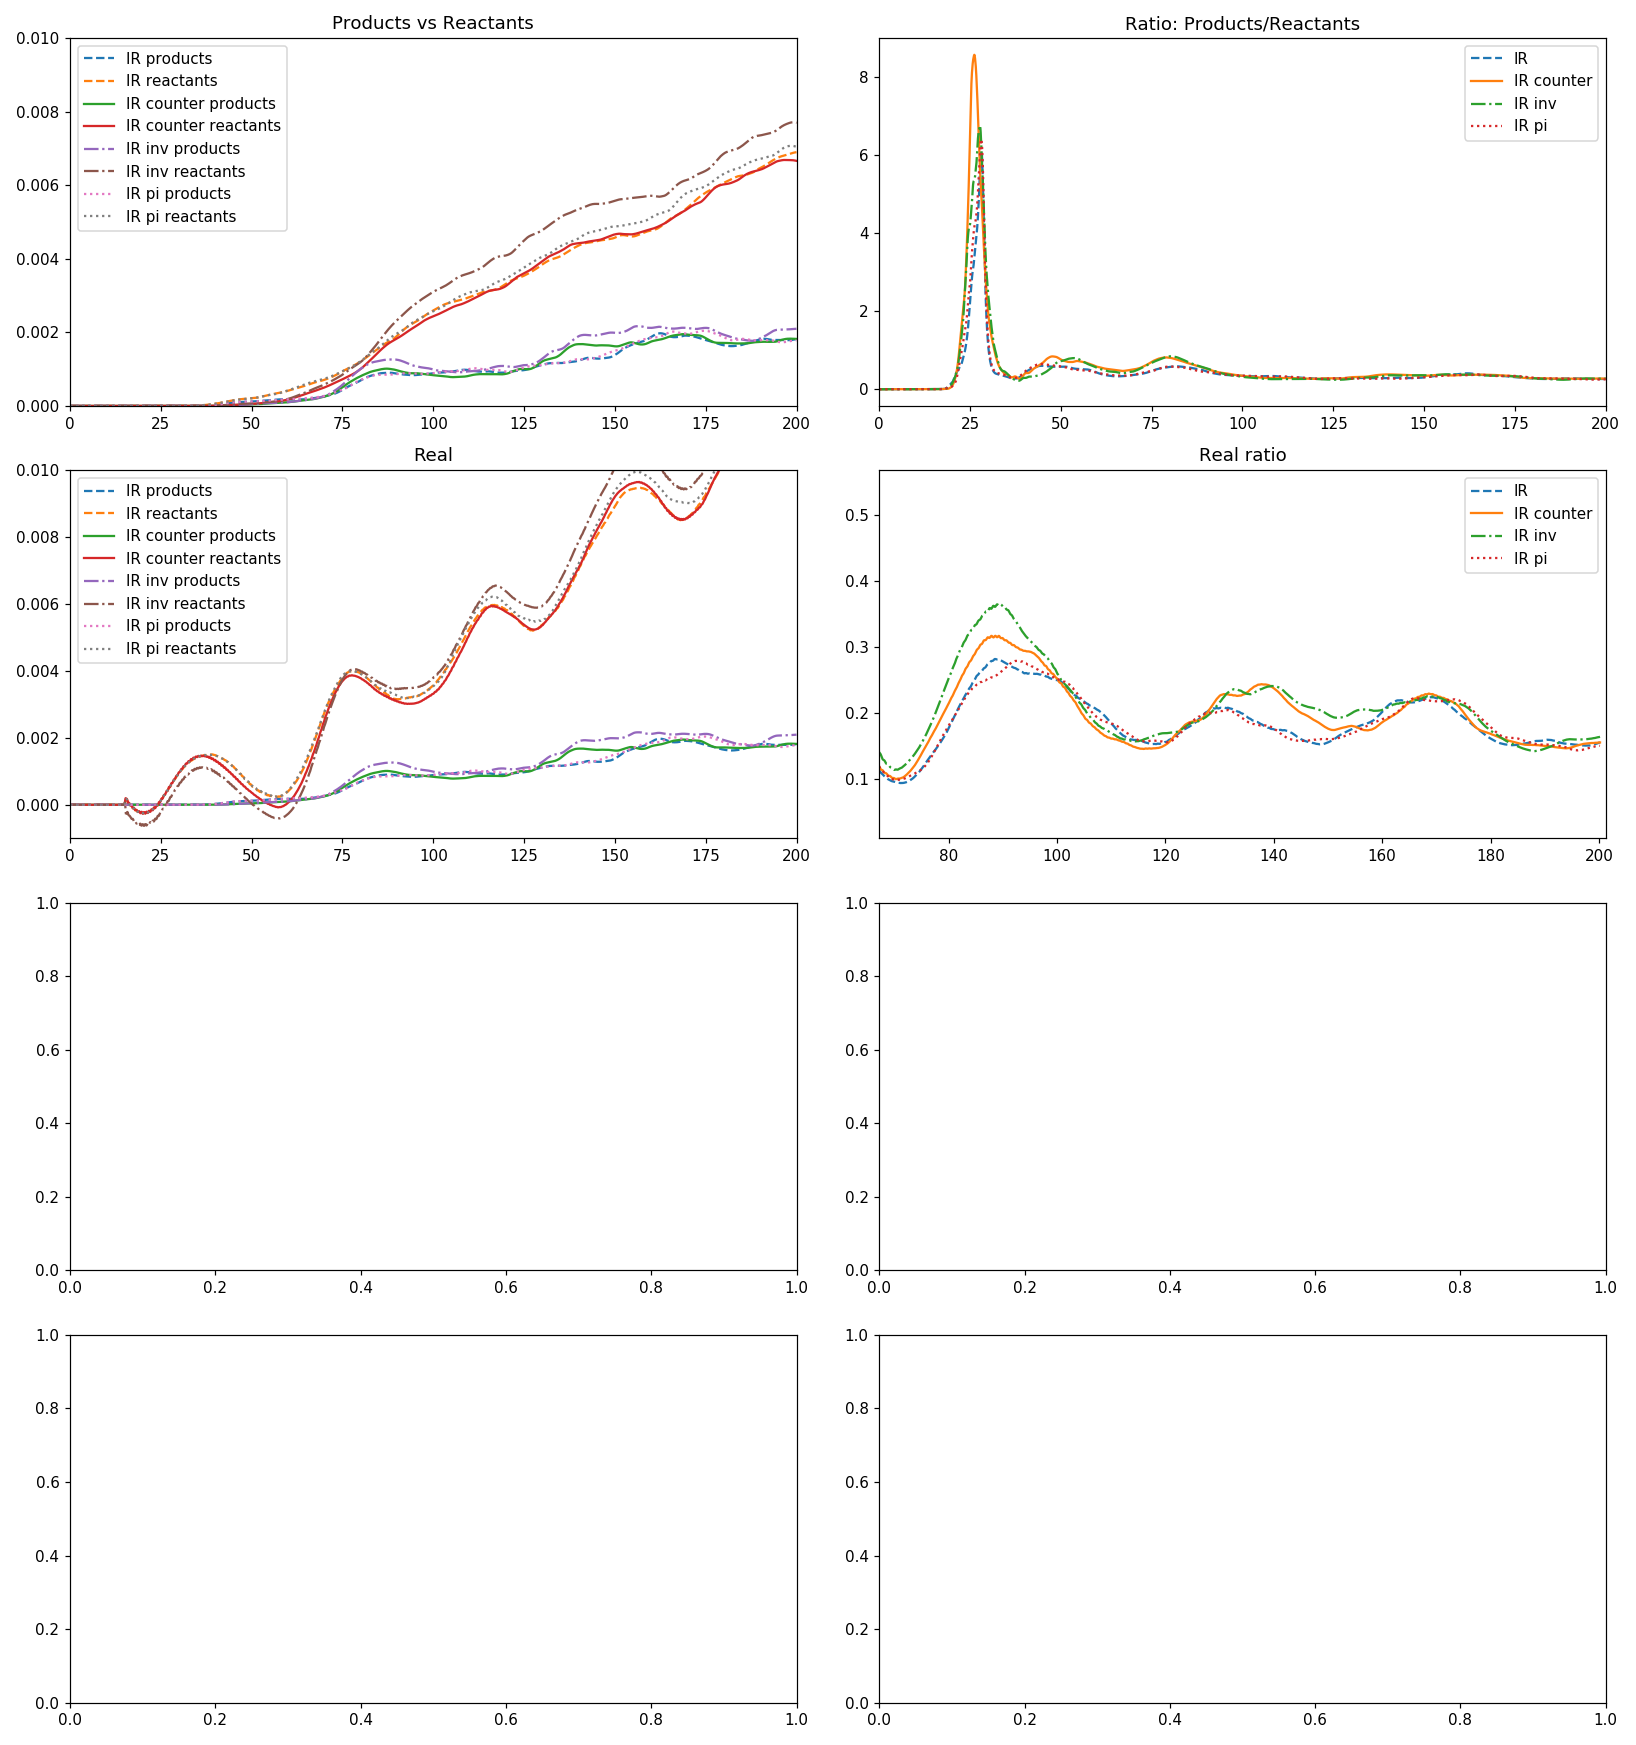

In [80]:
fig, [[ax0, ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(15,16))

ax0.plot(c['fs'].iloc[:,1],  c['Products'], label='IR products',ls='--')
ax0.plot(c['fs'].iloc[:,1],  c['Reactants'], label='IR reactants',ls='--')
ax0.plot(d['fs'].iloc[:,1],  d['Products'], label='IR counter products')
ax0.plot(d['fs'].iloc[:,1],  d['Reactants'], label='IR counter reactants')
ax0.plot(e['fs'].iloc[:,1],  e['Products'], label='IR inv products',ls='-.')
ax0.plot(e['fs'].iloc[:,1],  e['Reactants'], label='IR inv reactants',ls='-.')
ax0.plot(f['fs'].iloc[:,1],  f['Products'], label='IR pi products',ls=':')
ax0.plot(f['fs'].iloc[:,1],  f['Reactants'], label='IR pi reactants',ls=':')
ax0.set_title(title1)
ax0.set_xlim(0,200)
ax0.set_ylim(0,0.01)
ax0.legend()

ax1.plot(c['fs'].iloc[:,1],     c['ratio'], label='IR',ls='--')
ax1.plot(d['fs'].iloc[:,1],     d['ratio'], label='IR counter')
ax1.plot(e['fs'].iloc[:,1],     e['ratio'], label='IR inv',ls='-.')
ax1.plot(f['fs'].iloc[:,1],     f['ratio'], label='IR pi',ls=':')
ax1.set_title(title2)
ax1.set_xlim(0,200)
ax1.legend()

ax2.plot(c['fs'].iloc[:,1],  c['Real Products'], label='IR products',ls='--')
ax2.plot(c['fs'].iloc[:,1],  c['Real Reactants'], label='IR reactants',ls='--')
ax2.plot(d['fs'].iloc[:,1],  d['Real Products'], label='IR counter products')
ax2.plot(d['fs'].iloc[:,1],  d['Real Reactants'], label='IR counter reactants')
ax2.plot(e['fs'].iloc[:,1],  e['Real Products'], label='IR inv products',ls='-.')
ax2.plot(e['fs'].iloc[:,1],  e['Real Reactants'], label='IR inv reactants',ls='-.')
ax2.plot(f['fs'].iloc[:,1],  f['Real Products'], label='IR pi products',ls=':')
ax2.plot(f['fs'].iloc[:,1],  f['Real Reactants'], label='IR pi reactants',ls=':')
ax2.set_title('Real')
ax2.set_xlim(0,200)
ax2.set_ylim(-0.001,0.01)
ax2.legend()

ax3.plot(c['fs'].iloc[:,1],     c['Real ratio'], label='IR',ls='--')
ax3.plot(d['fs'].iloc[:,1],     d['Real ratio'], label='IR counter')
ax3.plot(e['fs'].iloc[:,1],     e['Real ratio'], label='IR inv',ls='-.')
ax3.plot(f['fs'].iloc[:,1],     f['Real ratio'], label='IR pi',ls=':')
ax3.set_title('Real ratio')
ax3.set_xlim(0,200)
ax3.legend()

fig.tight_layout();

<IPython.core.display.Javascript object>


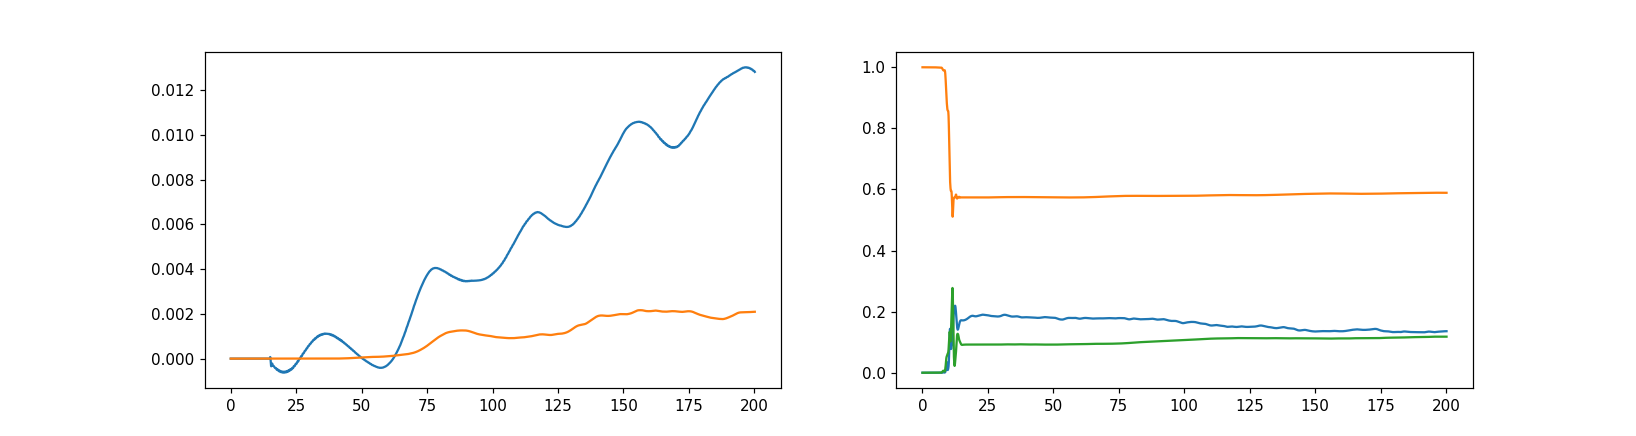

In [69]:
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(15,4))

ax0.plot(e['fs'].iloc[:,1], e['Real Reactants'])
ax0.plot(e['fs'].iloc[:,1], e['Real Products'])

ax1.plot(e['fs'].iloc[:,1], e['S2'])
ax1.plot(e['fs'].iloc[:,1], e['S0'])
ax1.plot(e['fs'].iloc[:,1], e['S1'])

# IR vs UV

<IPython.core.display.Javascript object>


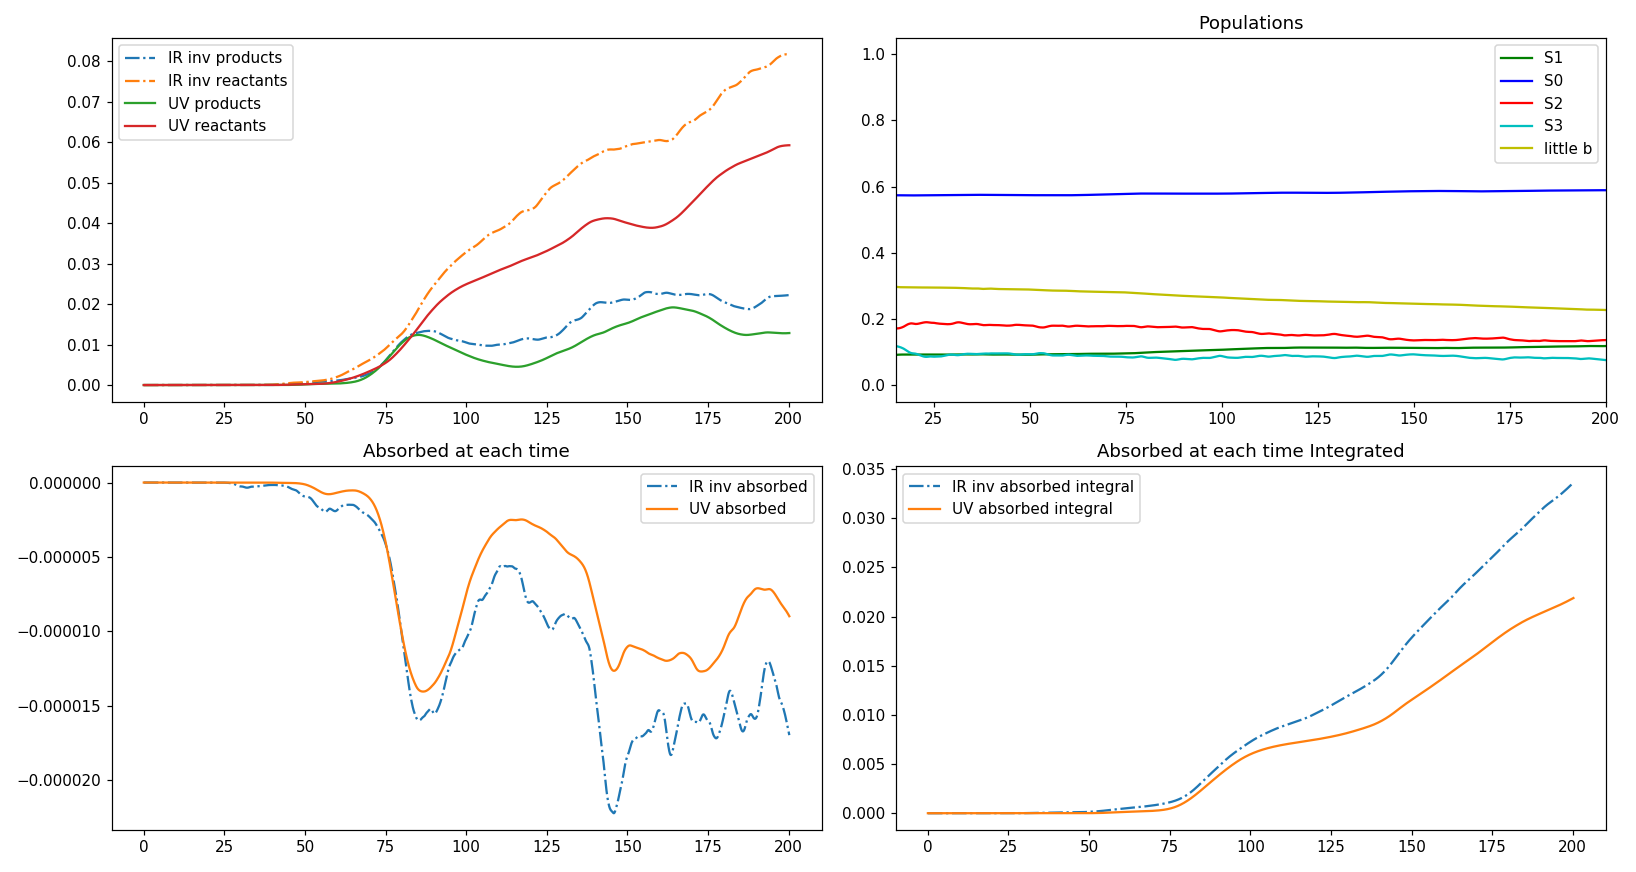

In [37]:
fig, [[ax0, ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(15,8))

ax0.plot(e['fs'].iloc[:,1],     e['Products']/normIR1, label='IR inv products',ls='-.')
ax0.plot(e['fs'].iloc[:,1],     e['Reactants']/normIR1, label='IR inv reactants',ls='-.')
ax0.plot(b['fs'].iloc[:,1],     b['Products']/normUV1, label='UV products')
ax0.plot(b['fs'].iloc[:,1],     b['Reactants']/normUV1, label='UV reactants')
ax0.legend()

ax1.plot(e['fs'].iloc[:,1], e['S1'], label='S1', color='g')
ax1.plot(e['fs'].iloc[:,1], e['S0'], label='S0', color='b')
ax1.plot(e['fs'].iloc[:,1], e['S2'], label='S2', color='r')
ax1.plot(e['fs'].iloc[:,1], e['S3'], label='S3', color='c')
#ax1.plot(e['fs'].iloc[:,1], e['S2']+e['S3'], label='2+3', color='y')
ax1.plot(e['fs'].iloc[:,1], e['mediana'], label='little b', color='y')
ax1.set_title('Populations')
ax1.set_xlim(15,200)
ax1.legend()

ax2.plot(e['fs'].iloc[:,1],     e['Norm S0']/normIR1, label='IR inv absorbed',ls='-.')
ax2.plot(b['fs'].iloc[:,1],     b['Norm S0']/normUV1, label='UV absorbed')
ax2.set_title(title3)
ax2.legend()


ax3.plot(e['fs'].iloc[:,1],     -np.cumsum(e['Norm S0']/normIR1), label='IR inv absorbed integral',ls='-.')
ax3.plot(b['fs'].iloc[:,1],     -np.cumsum(b['Norm S0']/normUV1), label='UV absorbed integral')
ax3.set_title(title3 + " Integrated")
ax3.legend()

fig.tight_layout();

<IPython.core.display.Javascript object>


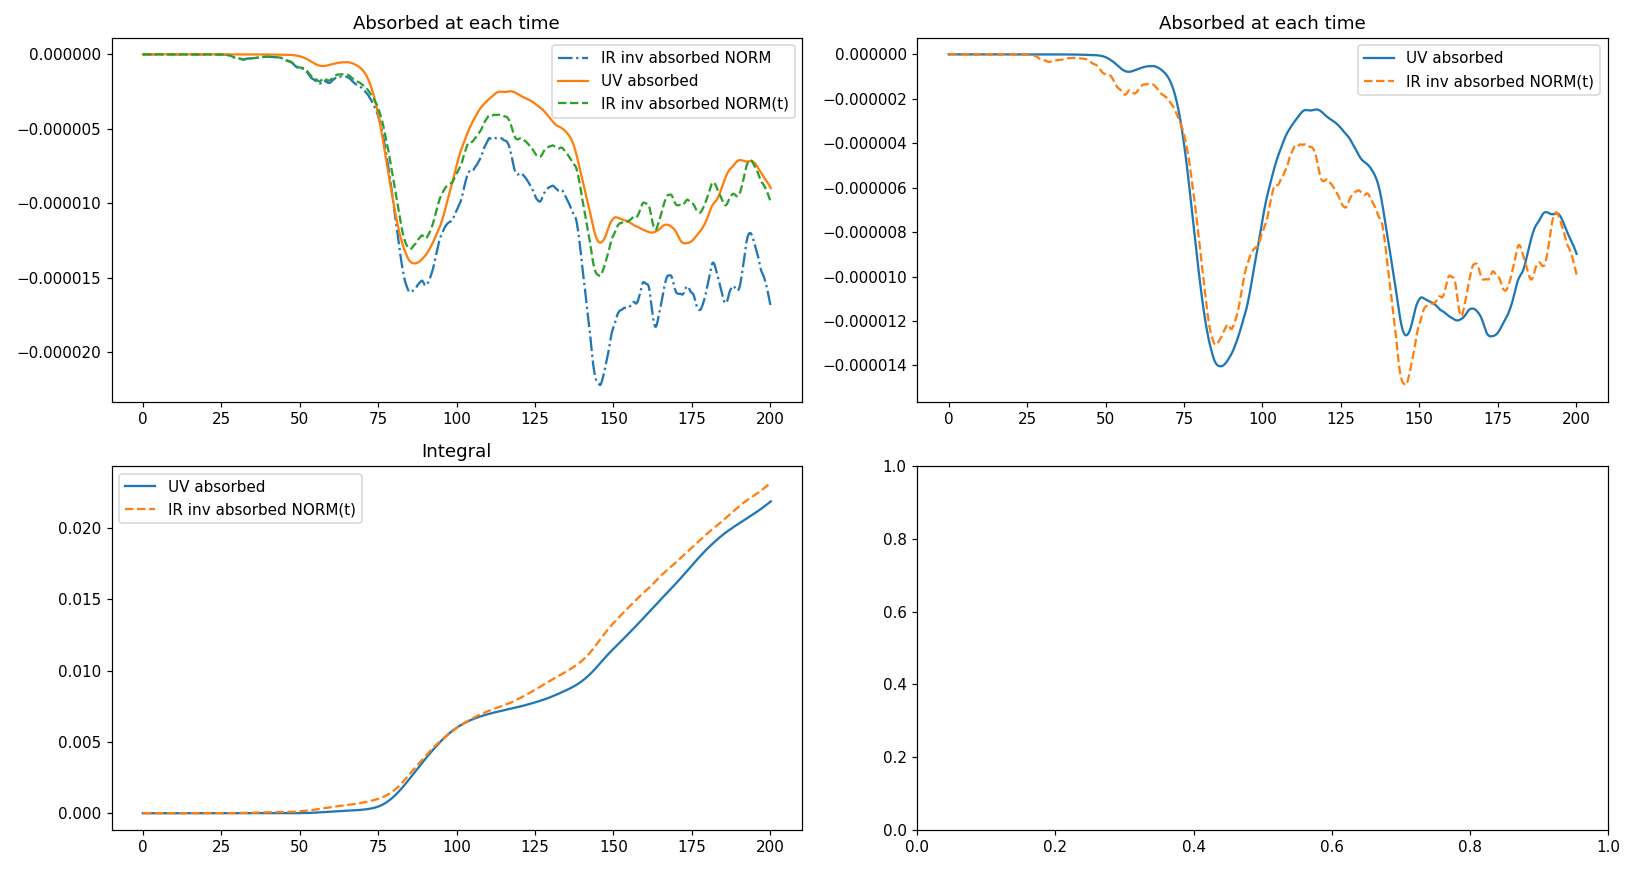

In [38]:
#e.plot('fs','Norm_factor')
#e.plot('fs','mediana_two')
fig, [[ax2, ax1],[ax3,ax4]] = plt.subplots(2,2,figsize=(15,8))
ax2.plot(e['fs'].iloc[:,1],     e['Norm S0']/normIR1, label='IR inv absorbed NORM',ls='-.')
ax2.plot(b['fs'].iloc[:,1],     b['Norm S0']/normUV1, label='UV absorbed')
ax2.plot(e['fs'].iloc[:,1],     e['Norm S0']/e['Norm_factor'], label='IR inv absorbed NORM(t)',ls='--')
ax2.set_title(title3)
ax2.legend()

ax1.plot(b['fs'].iloc[:,1],     b['Norm S0']/normUV1, label='UV absorbed')
ax1.plot(e['fs'].iloc[:,1],     e['Norm S0']/e['Norm_factor'], label='IR inv absorbed NORM(t)',ls='--')
ax1.set_title(title3)
ax1.legend()

ax3.plot(b['fs'].iloc[:,1],     -np.cumsum(b['Norm S0']/normUV1),          label='UV absorbed')
ax3.plot(e['fs'].iloc[:,1],     -np.cumsum(e['Norm S0']/e['Norm_factor']), label='IR inv absorbed NORM(t)',ls='--')
ax3.set_title('Integral')
ax3.legend()

fig.tight_layout();

# short IR

<IPython.core.display.Javascript object>


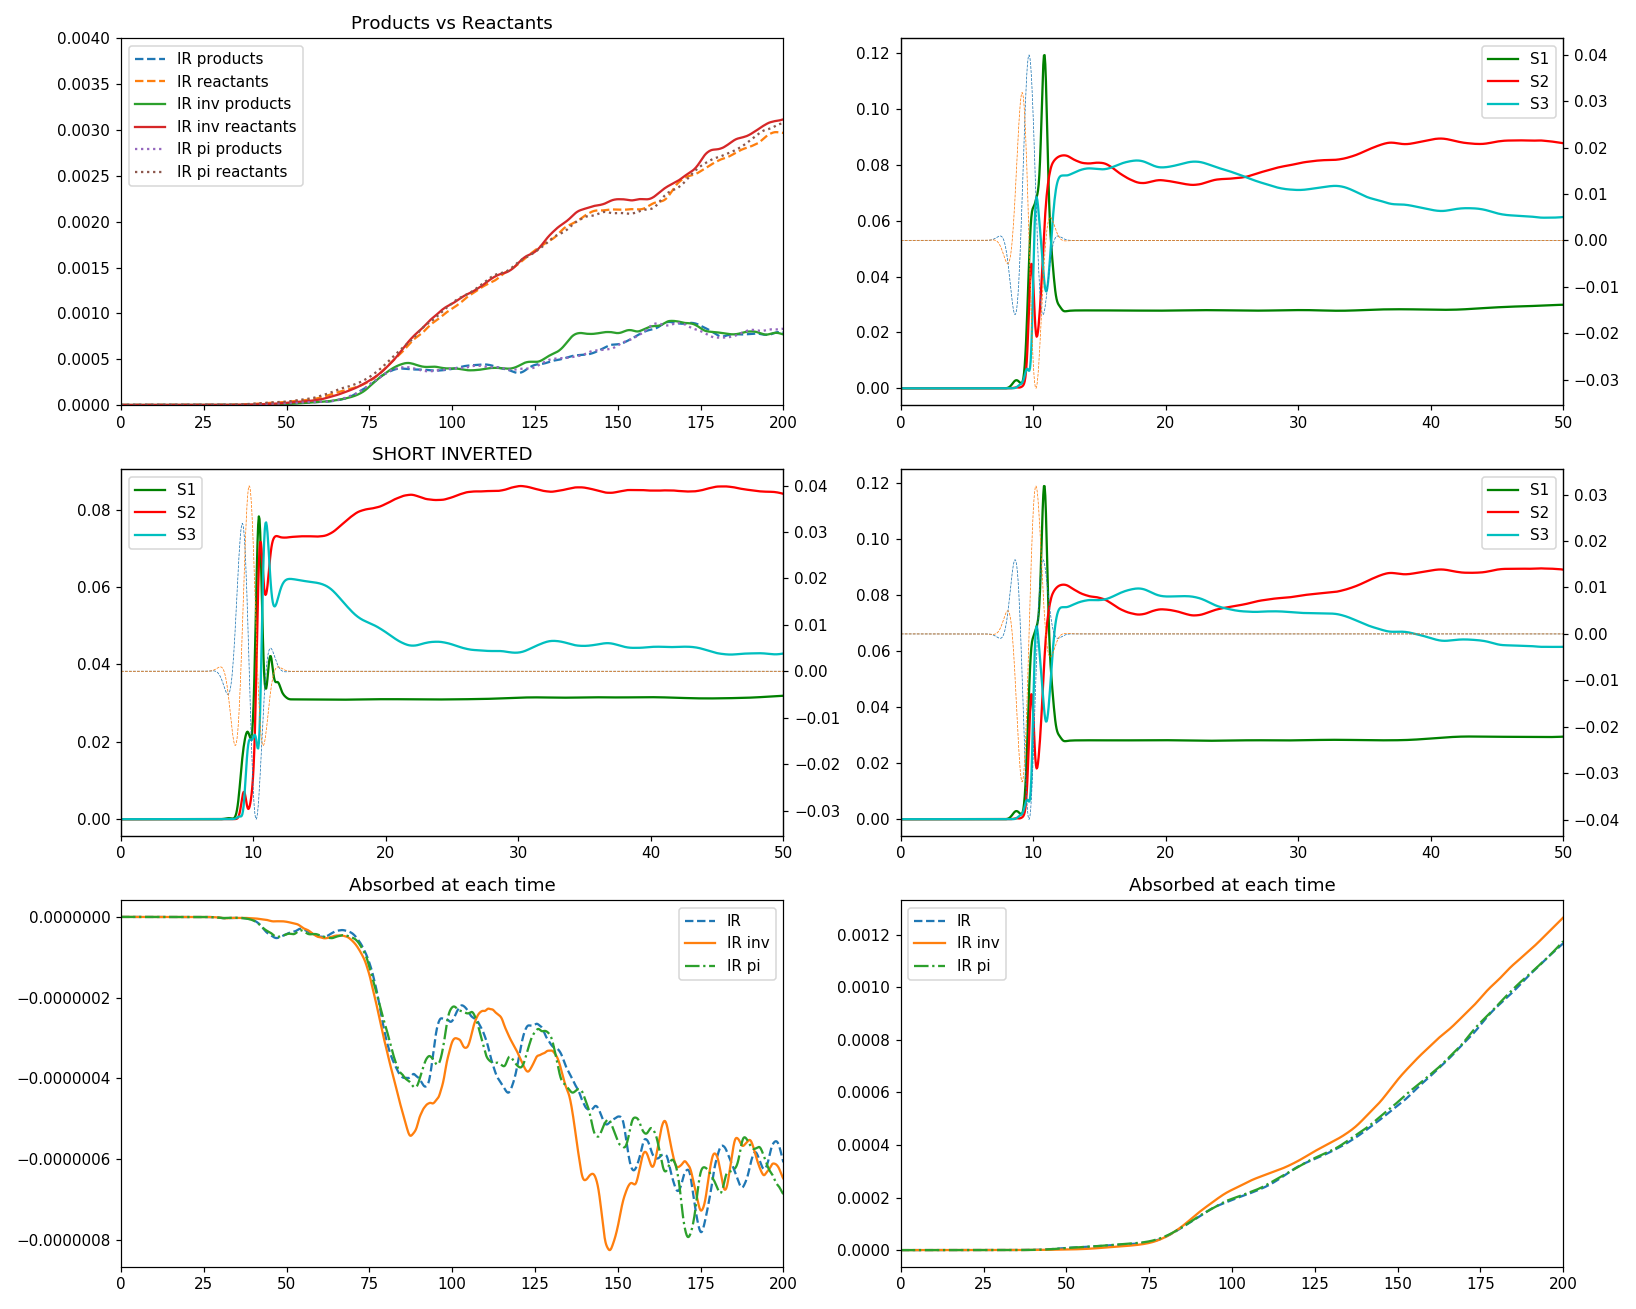

In [33]:
fig, [[ax0, ax1],[ax2,ax3],[ax4,ax5]] = plt.subplots(3,2,figsize=(15,12))

normG = 1
#normG = 0.523

ax0.plot(g['fs'].iloc[:,1],  g['Products'], label='IR products',ls='--')
ax0.plot(g['fs'].iloc[:,1],  g['Reactants'], label='IR reactants',ls='--')
ax0.plot(h['fs'].iloc[:,1],  h['Products'], label='IR inv products')
ax0.plot(h['fs'].iloc[:,1],  h['Reactants'], label='IR inv reactants')
ax0.plot(i['fs'].iloc[:,1],  i['Products'], label='IR pi products',ls=':')
ax0.plot(i['fs'].iloc[:,1],  i['Reactants'], label='IR pi reactants',ls=':')
ax0.set_title(title1)
ax0.set_xlim(0,200)
ax0.set_ylim(0,0.004)
ax0.legend()

ax1.plot(g['fs'].iloc[:,1], g['S1'],label='S1', color='g')
ax1.plot(g['fs'].iloc[:,1], g['S2'],label='S2', color='r')
ax1.plot(g['fs'].iloc[:,1], g['S3'],label='S3', color='c')
ax11 = ax1.twinx()
ax11.plot(g['fs'].iloc[:,1], g['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax11.plot(g['fs'].iloc[:,1], g['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax1.set_xlim(0,50)
ax1.legend()

ax2.plot(h['fs'].iloc[:,1], h['S1'],label='S1', color='g')
ax2.plot(h['fs'].iloc[:,1], h['S2'],label='S2', color='r')
ax2.plot(h['fs'].iloc[:,1], h['S3'],label='S3', color='c')
ax22 = ax2.twinx()
ax22.plot(h['fs'].iloc[:,1], h['Xpulse'],label='X_pulse', ls='--', lw=.5)
ax22.plot(h['fs'].iloc[:,1], h['Ypulse'],label='Y_pulse', ls='--', lw=.5)
ax2.set_xlim(0,50)
ax2.set_title('SHORT INVERTED')
ax2.legend()

ax3.plot(i['fs'].iloc[:,1], i['S1'],label='S1', color='g')
ax3.plot(i['fs'].iloc[:,1], i['S2'],label='S2', color='r')
ax3.plot(i['fs'].iloc[:,1], i['S3'],label='S3', color='c')
ax33 = ax3.twinx()
ax33.plot(i['fs'].iloc[:,1], i['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax33.plot(i['fs'].iloc[:,1], i['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax3.set_xlim(0,50)
ax3.legend()

ax4.plot(g['fs'].iloc[:,1],     g['Norm S0'], label='IR',ls='--')
ax4.plot(h['fs'].iloc[:,1],     h['Norm S0'], label='IR inv')
ax4.plot(i['fs'].iloc[:,1],     i['Norm S0'], label='IR pi',ls='-.')
ax4.set_title(title3)
ax4.set_xlim(0,200)
ax4.legend()

ax5.plot(g['fs'].iloc[:,1],     -np.cumsum(g['Norm S0']), label='IR',ls='--')
ax5.plot(h['fs'].iloc[:,1],     -np.cumsum(h['Norm S0']), label='IR inv')
ax5.plot(i['fs'].iloc[:,1],     -np.cumsum(i['Norm S0']), label='IR pi',ls='-.')
ax5.set_title(title3)
ax5.set_xlim(0,200)
ax5.legend()

fig.tight_layout()

# short UV with CEP 0 and PI

<IPython.core.display.Javascript object>


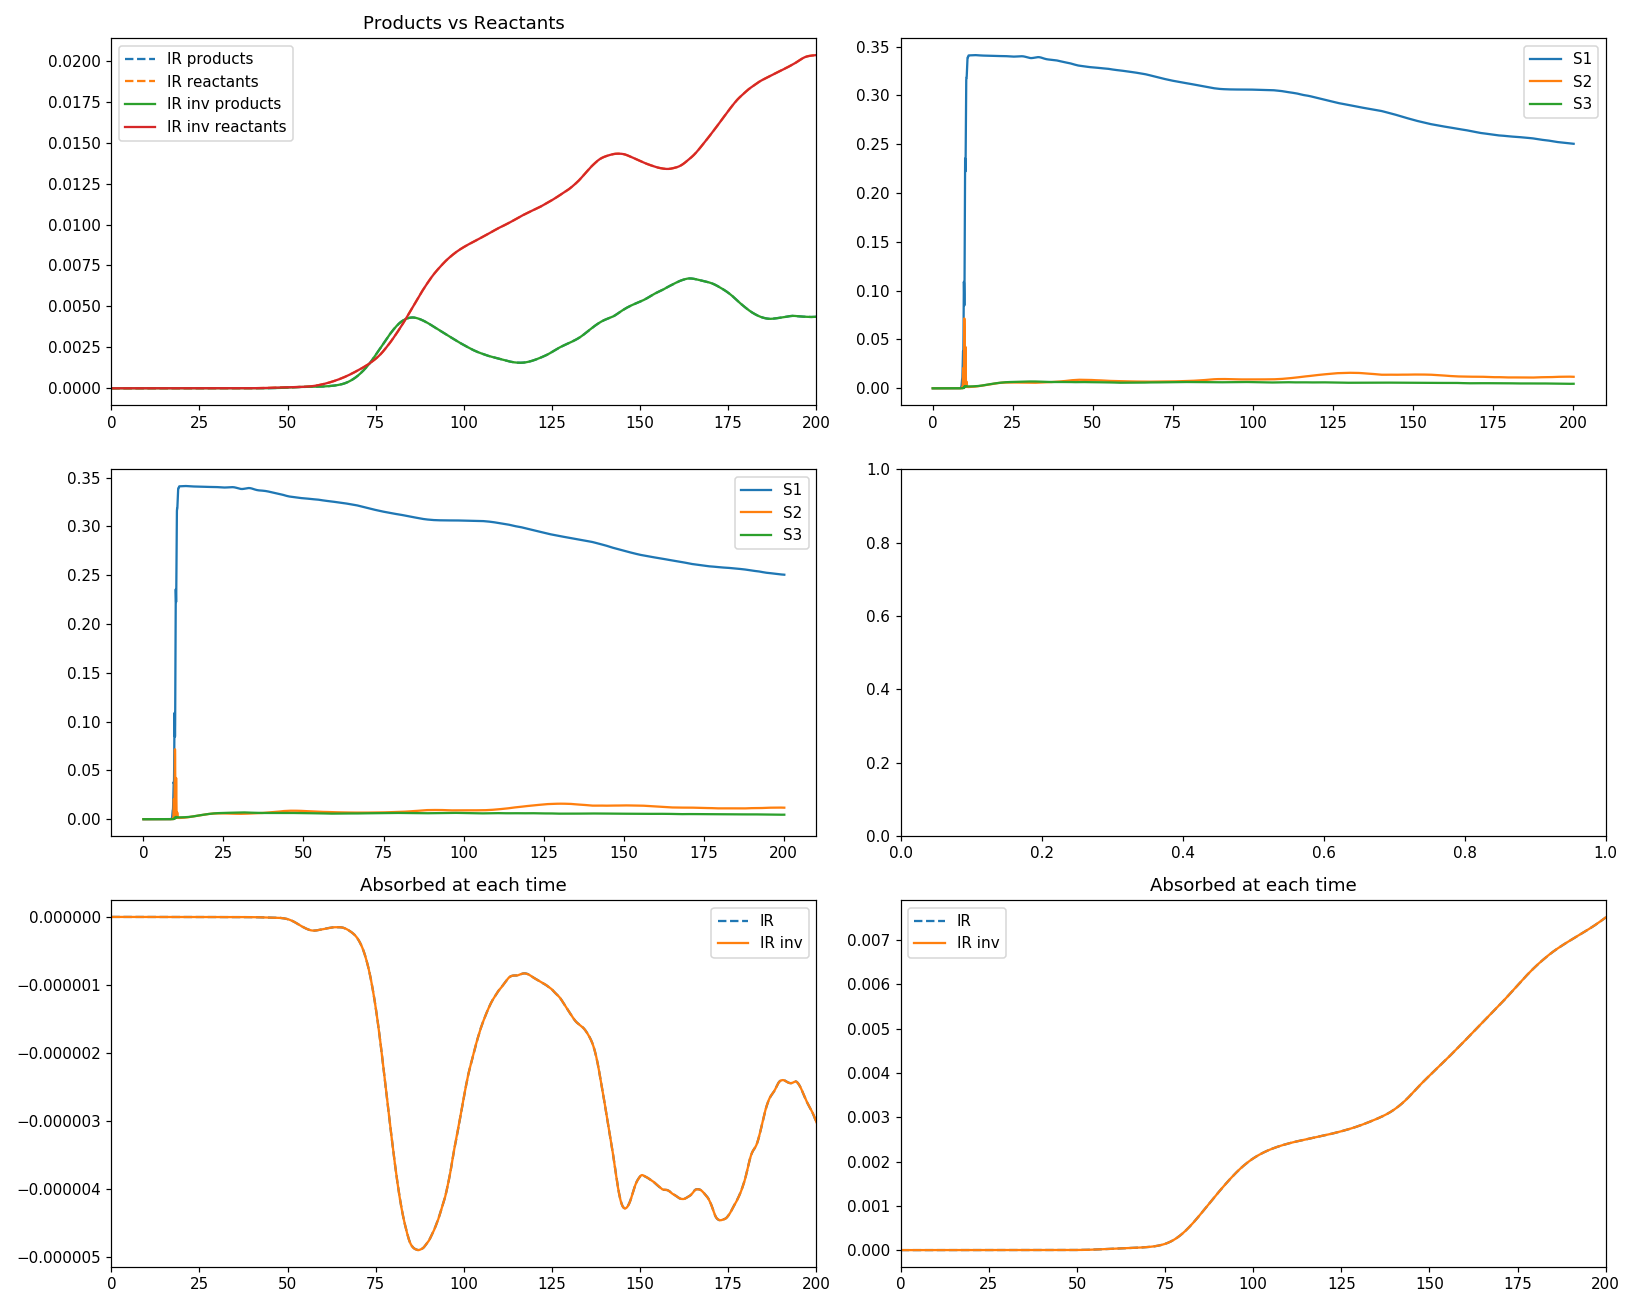

In [9]:
fig, [[ax0, ax1],[ax2,ax3],[ax4,ax5]] = plt.subplots(3,2,figsize=(15,12))

normG = 1
#normG = 0.523

ax0.plot(l['fs'].iloc[:,1],  l['Products'],  label='IR products',ls='--')
ax0.plot(l['fs'].iloc[:,1],  l['Reactants'], label='IR reactants',ls='--')
ax0.plot(m['fs'].iloc[:,1],  m['Products'],  label='IR inv products')
ax0.plot(m['fs'].iloc[:,1],  m['Reactants'], label='IR inv reactants')
ax0.set_title(title1)
ax0.set_xlim(0,200)
#ax0.set_ylim(0,0.004)
ax0.legend()

ax1.plot(l['fs'].iloc[:,1], l['S1'],label='S1')
ax1.plot(l['fs'].iloc[:,1], l['S2'],label='S2')
ax1.plot(l['fs'].iloc[:,1], l['S3'],label='S3')
ax1.legend()

ax2.plot(m['fs'].iloc[:,1], m['S1'],label='S1')
ax2.plot(m['fs'].iloc[:,1], m['S2'],label='S2')
ax2.plot(m['fs'].iloc[:,1], m['S3'],label='S3')
ax2.legend()

ax4.plot(l['fs'].iloc[:,1],     l['Norm S0'], label='IR',ls='--')
ax4.plot(m['fs'].iloc[:,1],     m['Norm S0'], label='IR inv')
ax4.set_title(title3)
ax4.set_xlim(0,200)
ax4.legend()

ax5.plot(l['fs'].iloc[:,1],     -np.cumsum(l['Norm S0']), label='IR',ls='--')
ax5.plot(m['fs'].iloc[:,1],     -np.cumsum(m['Norm S0']), label='IR inv')
ax5.set_title(title3)
ax5.set_xlim(0,200)
ax5.legend()

fig.tight_layout()
